In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import autocorrelation_plot
import matplotlib
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics

<h1>Содержание<span class="tocSkip"></span></h1>
</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:-данные-просемплированы-и-проанализированы.-Обучены-разные-модели.-Удалось-достичь-RMSE-ниже-48." data-toc-modified-id="Вывод:-данные-просемплированы-и-проанализированы.-Обучены-разные-модели.-Удалось-достичь-RMSE-ниже-48.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод: данные просемплированы и проанализированы. Обучены разные модели. Удалось достичь RMSE ниже 48.</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0a8eac610>]],
      dtype=object)

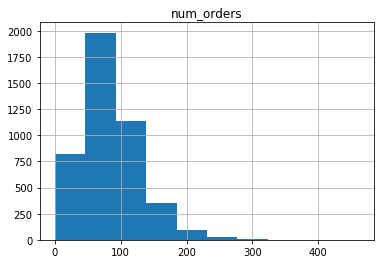

In [8]:
df.hist()

 Найдем коэффициент вариации: у нас относительно небольшой разброс целевого признака

In [9]:
print ('V = %f' % (df.std()/df.mean()))

V = 0.533314


In [10]:
df.index.is_monotonic

True

## Анализ

In [11]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(df['num_orders'])
SimpleTable(np.vstack([jb_test]), row)

JB,p-value,skew,kurtosis
3644.4335517264863,0.0,1.1885516779344458,6.762457138757449


Для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней

In [12]:
test = sm.tsa.adfuller(df['num_orders'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.068924289027949
p-value:  0.02894005140261345
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


In [13]:
dif = df.diff(periods=1).dropna()
m = dif['num_orders'].index[len(dif['num_orders'].index)//2+1]
r1 = sm.stats.DescrStatsW(dif['num_orders'][m:])
r2 = sm.stats.DescrStatsW(dif['num_orders'][:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.9587910561476498


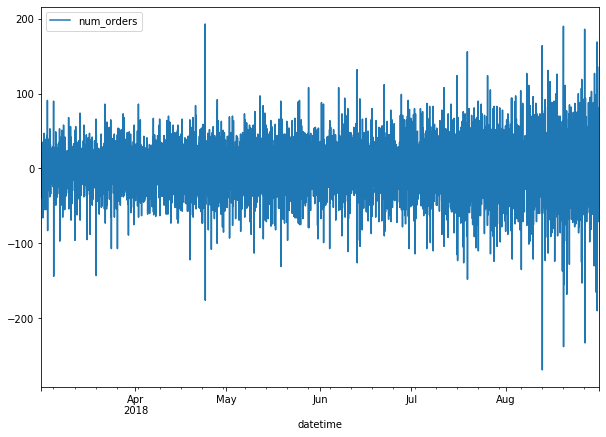

In [14]:
dif.plot(figsize=(10,7))

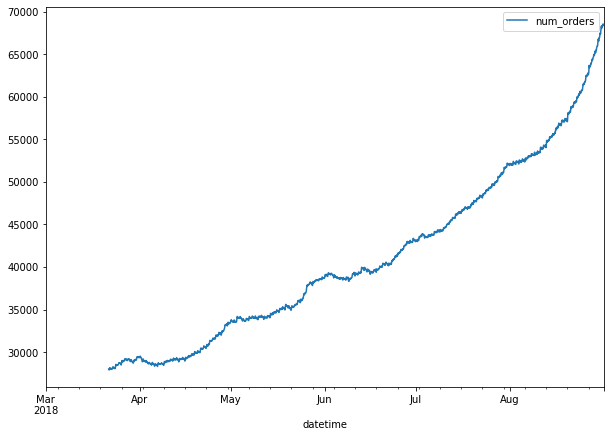

In [15]:
df.rolling(500).sum().plot(figsize = [10,7])

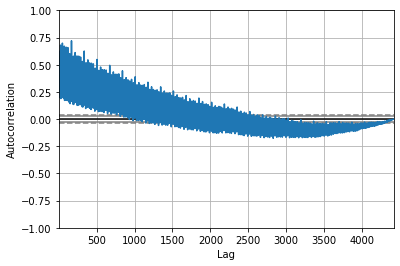

<Figure size 720x504 with 0 Axes>

In [16]:
autocorrelation_plot(df)
pyplot.figure(figsize=(10,7))
pyplot.show()


<div class="alert alert-block alert-info">
<b>Совет: </b> Сам график желательно было сделать шире.
</div>

In [17]:
#df = df.resample('1H').sum()

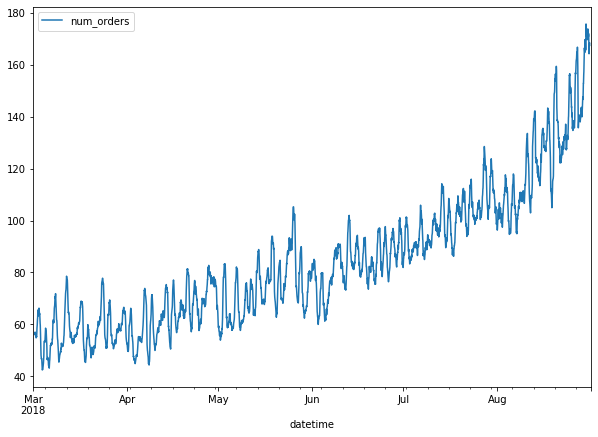

In [18]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(figsize = [10,7])

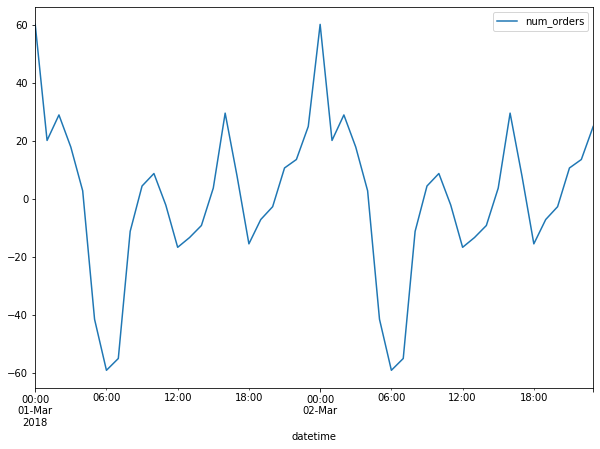

In [19]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 23:00:00'].plot(figsize = [10,7])

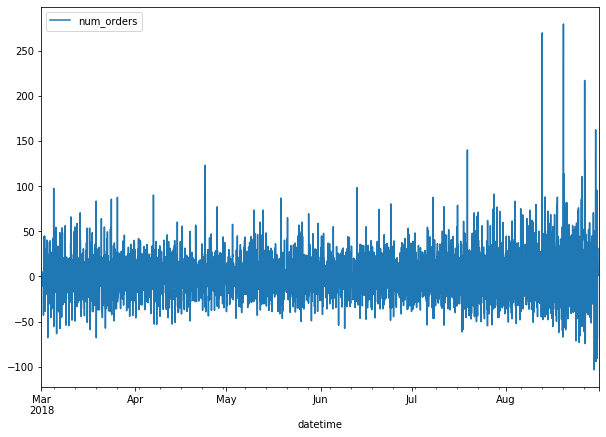

In [20]:
decomposed.resid.plot(figsize = [10,7])

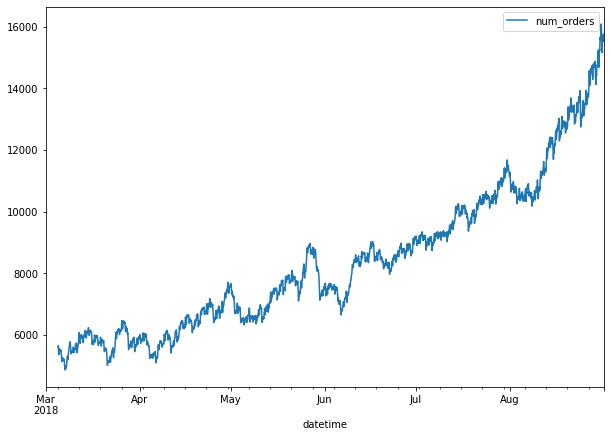

In [22]:
df.shift(fill_value=0).rolling(100).sum().plot(figsize = [10,7])

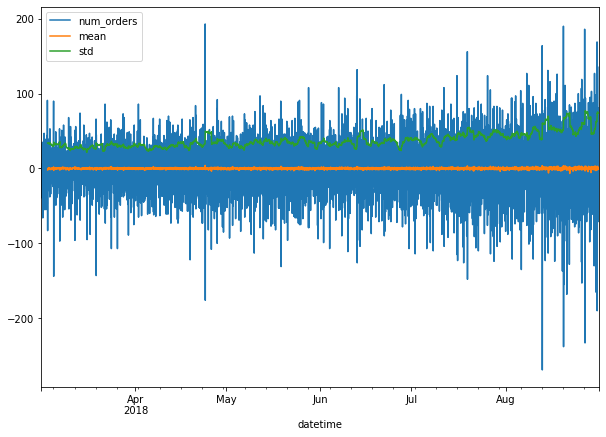

In [23]:

dif['mean'] = dif['num_orders'].rolling(50).mean()
dif['std'] = dif['num_orders'].rolling(50).std()
dif.plot(figsize = [10,7])

## ARIMA

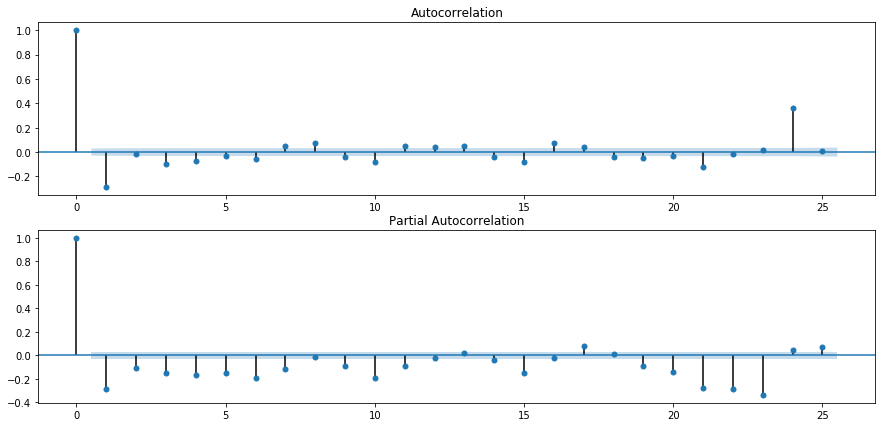

In [24]:
from matplotlib import figure
fig = figure.Figure( figsize =(15,7) )
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(dif['num_orders'].values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(dif['num_orders'], lags=25, ax=ax2)

In [25]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())


2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [26]:
#src_data_model = otg[:'2013-05-26']
model = sm.tsa.ARIMA(df, order=(1,1,1), freq='H').fit(full_output=False, disp=0)

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.num_orders   No. Observations:                 4415
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -21754.255
Method:                       css-mle   S.D. of innovations             33.382
Date:                Fri, 24 Dec 2021   AIC                          43516.511
Time:                        07:36:10   BIC                          43542.082
Sample:                    03-01-2018   HQIC                         43525.530
                         - 08-31-2018                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0222      0.006      3.886      0.000       0.011       0.033
ar.L1.D.num_orders     0.4548      0.014     33.542      0.000       0.428       0.481
ma.L1.D.num_orders    -0.9941      0.001   -698.387      0.000      -0.997      -0.991
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1987           +0.0000j            2.1987            0.0000
MA.1            1.0060           +0.0000j            1.0060            0.0000
-----------------------------------------------------------------------------
"""

In [28]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


,Q-stat,p-value
0,0.453949,5.004658e-01
1,23.958103,6.274280e-06
2,36.446497,6.025208e-08
3,62.839667,7.334163e-13
4,81.307382,4.469546e-16
5,106.549075,1.075157e-20
6,108.359463,2.009941e-20
7,118.999395,5.334306e-22
8,129.021325,1.884830e-23
9,153.996896,5.604888e-28


In [29]:
pred = model.predict('2018-08-13','2018-08-31', typ='levels')
trn = df['2018-08-13':]
r2 = r2_score(trn, pred)
print ('R^2: %1.2f' % r2)

R^2: 0.24


In [30]:
metrics.rmse(trn,pred)

66.9057885135973

In [31]:
metrics.mae(trn,pred)

50.85037791446233

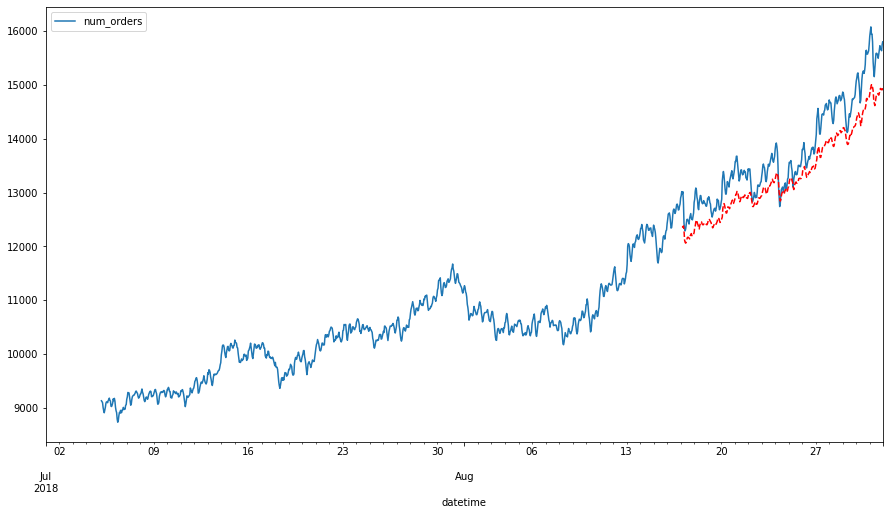

In [32]:
df['2018-07-01':].rolling(100).sum().plot(figsize=(15,8))
pred.rolling(100).sum().plot(style='r--')

## Обучение с помощью Линейной регрессии

Предсказание константной моделью

In [33]:
print("Среднее количество заказов такси:", test['num_orders'].mean())

pred_median = [train['num_orders'].median() for i in test['num_orders']]
print("RMSE:", mean_squared_error(test['num_orders'], pred_median)**0.5)

Среднее количество заказов такси: 139.55656108597285
RMSE: 87.15277582981295


Предсказание предыдущим значением

In [34]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
print("RMSE:", mean_squared_error(test['num_orders'], pred_previous)**0.5)

RMSE: 58.856486242815066


In [35]:
def make_features(data, max_lag, rolling_mean_size):
    frame = data.copy()
    frame['hour'] = frame.index.hour
    frame['month'] = frame.index.month
    frame['day'] = frame.index.day
    frame['dayofweek'] = frame.index.dayofweek
   
    for lag in range(1, max_lag + 1):
        frame['lag_{}'.format(lag)] = frame['num_orders'].shift(lag)
    frame['rolling_mean'] = frame['num_orders'].shift().rolling(rolling_mean_size).mean()
    return(frame)

In [36]:
frame = make_features(df, 4, 4)
train, test = train_test_split(frame, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("RMSE обучающей выборки:", mean_squared_error(y_train, model.predict(X_train))**0.5)
print("RMSE тестовой выборки: ", mean_squared_error(y_test, pred)**0.5)

RMSE обучающей выборки: 30.500374252442192
RMSE тестовой выборки:  52.574506853736914


/home/jovyan/.local/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


## Тестирование

In [37]:
train.shape, test.shape

((3970, 10), (442, 10))

In [38]:
print(frame.shape[0]//10+1)

442


In [39]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    test_size=frame.shape[0]//10+1
)

In [40]:
train.shape, test.shape

((3970, 10), (442, 10))

In [41]:
def score_(model, X_train, X_test, y_train, y_test, early_stopping_rounds, metric):  
    eval_set = [(X_test, y_test)]

    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        early_stopping_rounds=early_stopping_rounds,
        eval_metric=metric)
    preds = model.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = mean_squared_error(y_test, pred_labels)
    return (accuracy**0.5)

In [42]:
%%time
model = LGBMRegressor(n_estimators=1000, random_state=12345, n_jobs=-1)
score_(model, X_train, X_test, y_train, y_test, 100, 'rmse')

[1]	valid_0's rmse: 81.2465	valid_0's l2: 6600.99
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 78.0685	valid_0's l2: 6094.69
[3]	valid_0's rmse: 75.5343	valid_0's l2: 5705.43
[4]	valid_0's rmse: 72.6105	valid_0's l2: 5272.28
[5]	valid_0's rmse: 70.1014	valid_0's l2: 4914.2
[6]	valid_0's rmse: 68.0492	valid_0's l2: 4630.7
[7]	valid_0's rmse: 66.2015	valid_0's l2: 4382.64
[8]	valid_0's rmse: 64.6859	valid_0's l2: 4184.27
[9]	valid_0's rmse: 62.9712	valid_0's l2: 3965.38
[10]	valid_0's rmse: 61.7451	valid_0's l2: 3812.46
[11]	valid_0's rmse: 60.3496	valid_0's l2: 3642.08
[12]	valid_0's rmse: 59.2538	valid_0's l2: 3511.01
[13]	valid_0's rmse: 57.8596	valid_0's l2: 3347.74
[14]	valid_0's rmse: 57.0734	valid_0's l2: 3257.38
[15]	valid_0's rmse: 56.2565	valid_0's l2: 3164.8
[16]	valid_0's rmse: 55.5432	valid_0's l2: 3085.05
[17]	valid_0's rmse: 54.4455	valid_0's l2: 2964.31
[18]	valid_0's rmse: 53.8322	valid_0's l2: 2897.91
[19]	valid_0's rmse: 53.3343	val

44.6161355062416

In [43]:
def eval(model, params):
    grid = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=ts_cv)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_test)                                                   
    accuracy = mean_squared_error(y_test, pred)
    accuracy**0.5
    print('RMSE', (accuracy**0.5))
    print(grid.best_params_)

In [44]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, n_jobs=-1)
eval(model, {'learning_rate':np.arange(0.1, 1, 0.2)})

RMSE 45.04210854822016
{'learning_rate': 0.1}
CPU times: user 27.2 s, sys: 351 ms, total: 27.6 s
Wall time: 27.9 s


In [45]:
%%time
model = LGBMRegressor(n_estimators=100, random_state=12345, learning_rate=0.1, n_jobs=-1)
eval(model, {'reg_lambda':np.arange(0, 20, 2)})

RMSE 45.06721877278898
{'reg_lambda': 2}
CPU times: user 1min 3s, sys: 971 ms, total: 1min 4s
Wall time: 1min 4s


In [46]:
%%time
model = LGBMRegressor(random_state=12345, learning_rate=0.3, n_jobs=-1, reg_lambda=2, n_estimators=100)
eval(model, {'reg_alpha':np.arange(0, 20, 2)})

RMSE 45.663327377973225
{'reg_alpha': 6}
CPU times: user 1min 4s, sys: 803 ms, total: 1min 5s
Wall time: 1min 6s


In [47]:
%%time
model = LGBMRegressor(random_state=12345, learning_rate=0.3, n_jobs=-1, reg_lambda=2, reg_alpha =10)
eval(model, {'n_estimators':[100,300]})

RMSE 44.605469503184395
{'n_estimators': 100}
CPU times: user 22.5 s, sys: 405 ms, total: 22.9 s
Wall time: 23.2 s


## Вывод: данные просемплированы и проанализированы. Обучены разные модели. Удалось достичь RMSE ниже 48. 